# TODO:
- [x] Ask Farbod if all ray-casted data (MSW + BMBF) is on the folder `MSW-BMBF data/Processed Raycast Data/`, inside the folders `CsvData MSW-Left` and `CsvData MSW-Right`
- [x] Ask about the meaning of the different hits `centerHit`, `centerHitGroup`, `boxHit`, `boxHitGroup`. Also, what is `presentObjectName` and `presentObjectGroup`
- [x] Best way (column) to check possible poor estimate of fixations? => `centerHitGroup` or `boxHitGroup`
- [x] FPS of the experiment (average)? -> last frame count (it should be 3070 if experiment finished) - first (400) / 90 (seconds). => Should be 29.6 FPS (~ 30 FPS)
- [x] Why the ray-casted CSV files sizes differ so much? Is it because unfinished experiments? => Yes, but mostly because the colliders values differ (text length on plain text files)
- [x] TAM scores. Do they come from each column or do they need to be calculated? So, `trust` column? => Direct scores, no need to calculate anything
- [x] Check Jasmine's presentation to know how to differentiate between saccades and fixations and apply it
- [x] Select all ray-casted data participants that answered the questionnaire
- [x] Find out why the participants count (colliders and questionnaires) differ from Farbod's notebook: https://github.com/farbod69/TAM-Data-Analyis/blob/master/Readme.md
- [x] Check if the `HitGroups` can be directly categorized between traffic-relevant and non-traffic-relevant
- [x] Take the preprocessed questionnaires, process them dropping the participants with missing trust values, remove duplicates
- [ ] Check NaNs properly on data_cleanup
- [ ] Remove examples that make no sense (e.g. age<10 and age>90)
- [ ] Plot the Trust variable, explore it like Age
- [ ] Reorganize dataframe
- [ ] Add multiprocessing while checking all participants
- [ ] Plot most fixated vs saccaded objects
- [ ] Plot Trust vs most-fixated objects/group (TR vs non-TR)

__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from multiprocessing import Manager, Pool, RawArray, cpu_count  # process parallelization
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.2f}".format

style = "darkgrid"
sns.set_style(style)  # set seaborn plotting style

cores = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {cores}")

Total CPU threads: 12


__Read participants cleaned data__

In [3]:
parts = pd.read_csv("./data/participants.csv", keep_default_na=False)
parts = parts.set_index("uid")  # set uid column as index (remove default)
parts

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,file,created,condition,frames
uid,,,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-ec61bab6e46741...,10.03.2020 01:11,RadioTalk,3070
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,Path_ MS Wissenschaft-RadioTalk-1fbde03890d94b...,18.02.2020 16:24,RadioTalk,3070
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,Path_ MS Wissenschaft-RadioTalk-1ad9eea672a945...,09.03.2020 21:31,RadioTalk,3070
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,Path_ MS Wissenschaft-TaxiDriver-461b2d80132f4...,10.03.2020 02:40,TaxiDriver,3070
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-4f300efb4a9941...,09.03.2020 22:19,RadioTalk,3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,Path_ MS Wissenschaft-RadioTalk-eda9175e9e1d41...,24.01.2020 13:28,RadioTalk,3070
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-b8c9e625f0744...,24.01.2020 15:06,TaxiDriver,3070
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-2cd78ad9a37945...,24.01.2020 11:49,RadioTalk,3070


__Descriptive statistics from each numerical variable__

In [4]:
cols = list(parts.describe().columns.difference(["frames"]))
parts[cols].describe()

,Age,Aviophobia,Driving,Ease,Intention,Play,Trust,Usefulness
count,7913.00,7913.00,7913.00,7913.00,7913.00,7913.00,7913.00,7913.00
mean,30.34,0.14,16.42,64.57,61.03,8.84,66.96,63.91
std,21.47,0.35,21.91,31.52,34.43,20.95,31.86,32.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,13.00,0.00,0.00,50.00,34.00,0.00,50.00,50.00
50%,21.00,0.00,6.00,70.00,66.00,1.00,75.00,70.00
75%,47.00,0.00,29.00,99.00,100.00,7.00,100.00,99.00
max,99.00,1.00,99.00,100.00,100.00,99.00,100.00,100.00


__Distribution of each numerical variable__

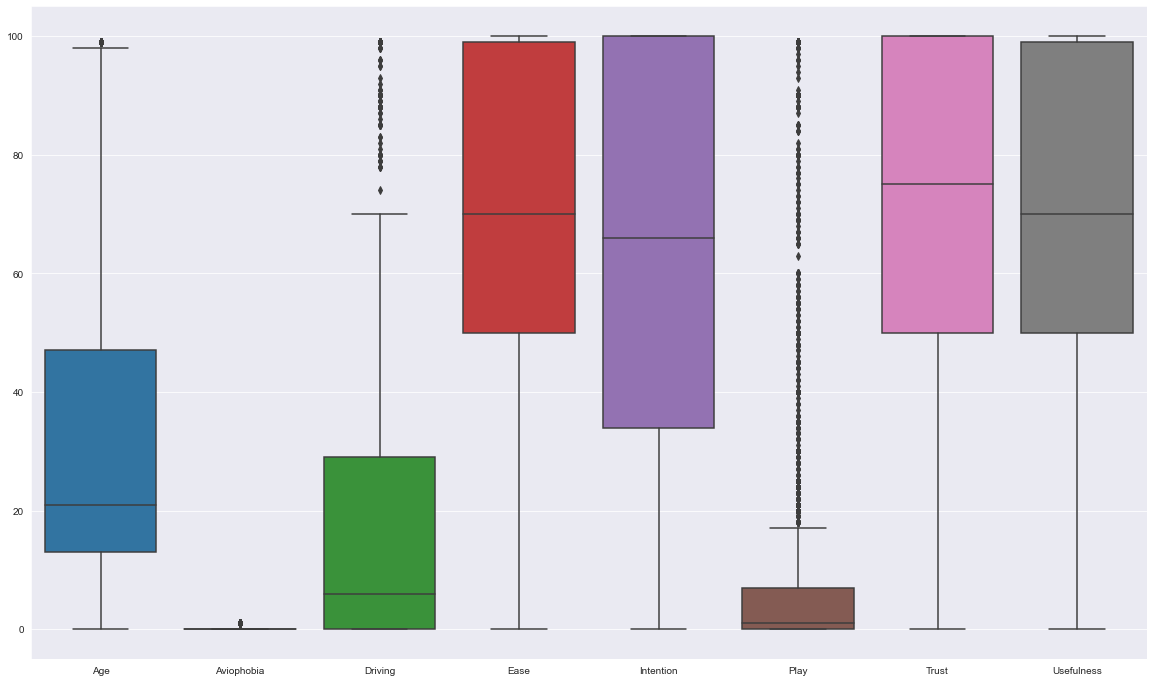

In [5]:
plt.figure(figsize=(20, 12))
sns.boxplot(data=parts[parts.columns.difference(["frames"])], order=cols)
plt.show()

__Correlation matrix of the numerical variables__

,Age,Aviophobia,Driving,Ease,Intention,Play,Trust,Usefulness
Age,1.00,-0.01,0.64,-0.14,-0.14,-0.05,-0.12,-0.14
Aviophobia,-0.01,1.00,0.08,-0.08,-0.06,0.18,-0.10,-0.06
Driving,0.64,0.08,1.00,-0.08,-0.09,0.25,-0.10,-0.11
Ease,-0.14,-0.08,-0.08,1.00,0.60,0.05,0.50,0.55
Intention,-0.14,-0.06,-0.09,0.60,1.00,0.03,0.51,0.65
Play,-0.05,0.18,0.25,0.05,0.03,1.00,-0.06,0.02
Trust,-0.12,-0.10,-0.10,0.50,0.51,-0.06,1.00,0.47
Usefulness,-0.14,-0.06,-0.11,0.55,0.65,0.02,0.47,1.00


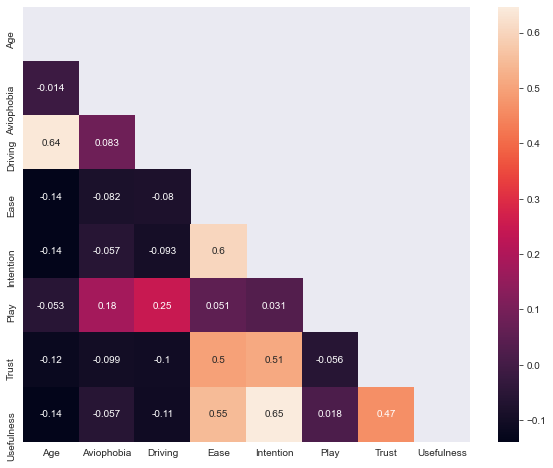

In [6]:
# remove the number of frames as it's uninformative
parts_an = copy.deepcopy(parts[parts.columns.difference(["frames"])])

cm_parts = parts_an.corr(method="pearson")
display(cm_parts)

# generate a mask to drop the upper part of the matrix (duplicated info)
mask = np.triu(np.ones_like(cm_parts, dtype=np.bool))

# figure size
plt.figure(figsize=(10, 8))

# display the correlation matrix as a heatmap
sns.heatmap(cm_parts, annot=True, mask=mask)
plt.show()

__Population count and density for each categorical variable__

,count,%
Gender,,
Male,4048,51.16
Female,3105,39.24
intersex,402,5.08
N/A,358,4.52


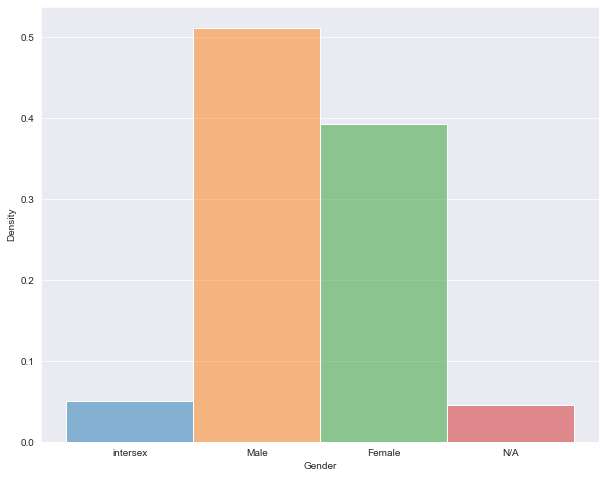

,count,%
VR,,
never,2676,33.82
less than 10 times,2517,31.81
once,1711,21.62
more than 10 times,1009,12.75


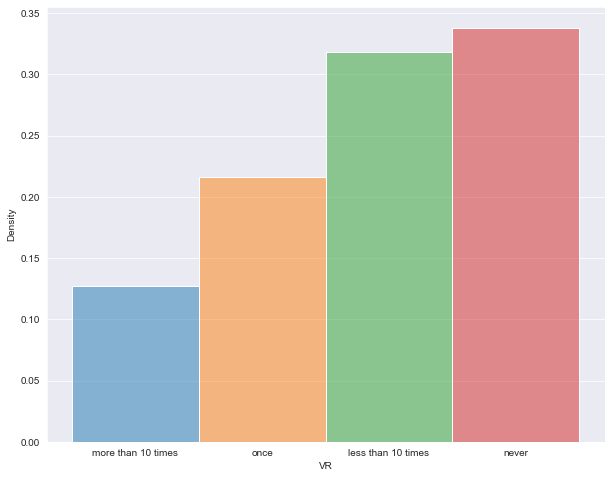

,count,%
expo,,
MSW,6763,85.47
BMBF,1150,14.53


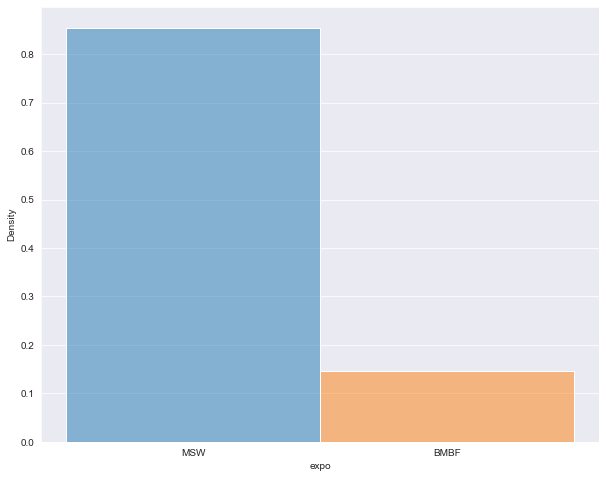

,count,%
condition,,
AVAS,3284,41.50
RadioTalk,3046,38.49
TaxiDriver,1583,20.01


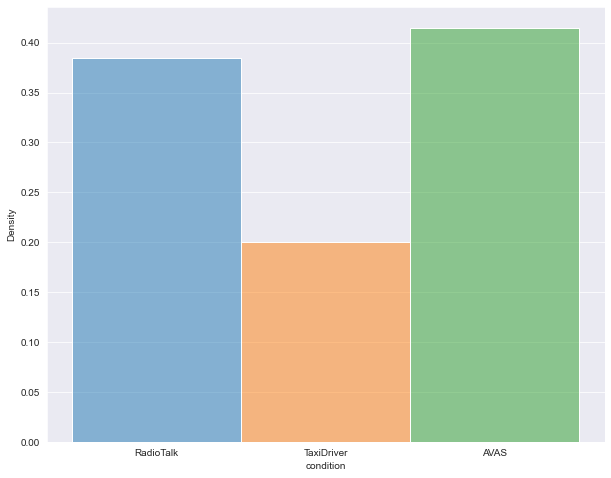

In [7]:
# categorical columns to compute descriptive statistics
cols = ["Gender", "VR", "expo", "condition"]
for col in cols:  # for each defined column
    counts = parts[col].value_counts()
    percents = parts[col].value_counts(normalize=True).mul(100)   
    df = pd.DataFrame({"count": counts, "%": percents})
    df.index.name = col
    # show counts vs percentage
    display(df)
    # plot directly without the previous calculations (seaborn takes care of it)
    plt.figure(figsize=(10, 8))
    ax = sns.histplot(data=parts, x=col, hue=col, stat="density", legend=False)
    ax.grid(False, axis="x")
    plt.show()

__Age distribution__

,Age
count,7913.00
mean,30.34
std,21.47
min,0.00
25%,13.00
50%,21.00
75%,47.00
max,99.00
mode,12.00


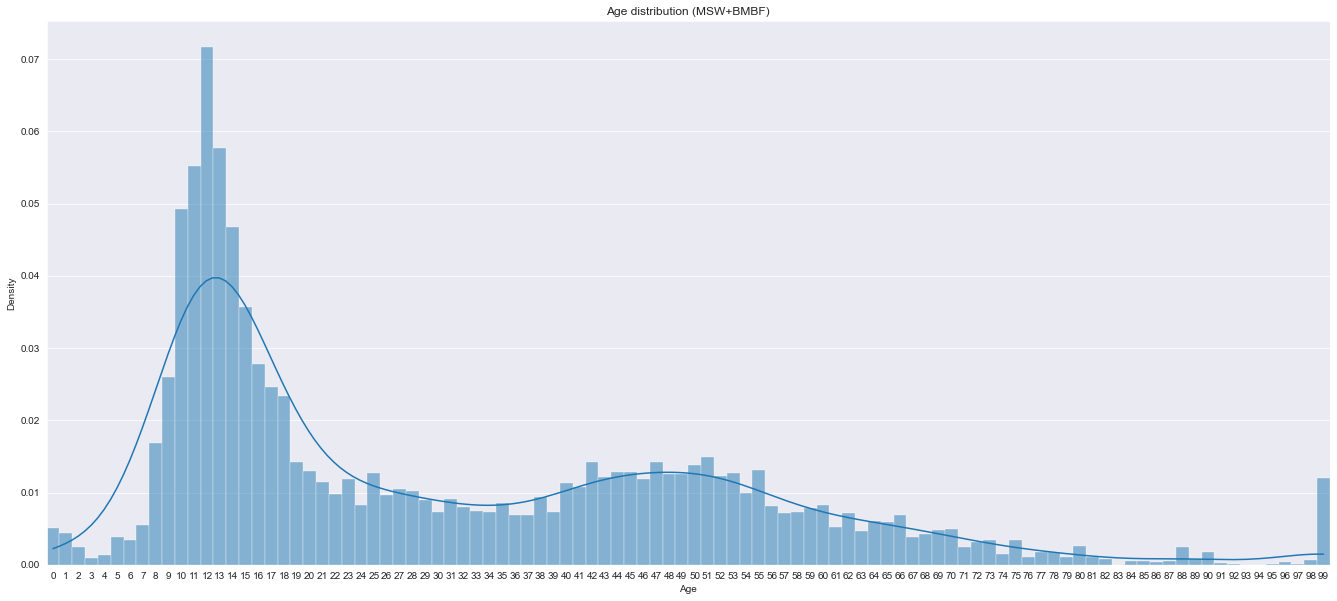

In [8]:
df_age = pd.DataFrame(parts.Age.describe())
df_age.loc["mode"] = parts.Age.mode()[0]
display(df_age)

ax = sns.histplot(
    data=parts,
    x="Age",
    kde=True,
    discrete=True,
    stat="density",
)
xticks = [a for a in range(100)]
ax.set(xticks=xticks, xticklabels=xticks)
ax.grid(False, axis="x")
ax.margins(x=0)

plt.title("Age distribution (MSW+BMBF)")
plt.gcf().set_size_inches(23, 10)
plt.show()

,%
Age,
12,7.17
13,5.78
11,5.52
10,4.93
14,4.68
...,...
96,0.04
91,0.03
92,0.01


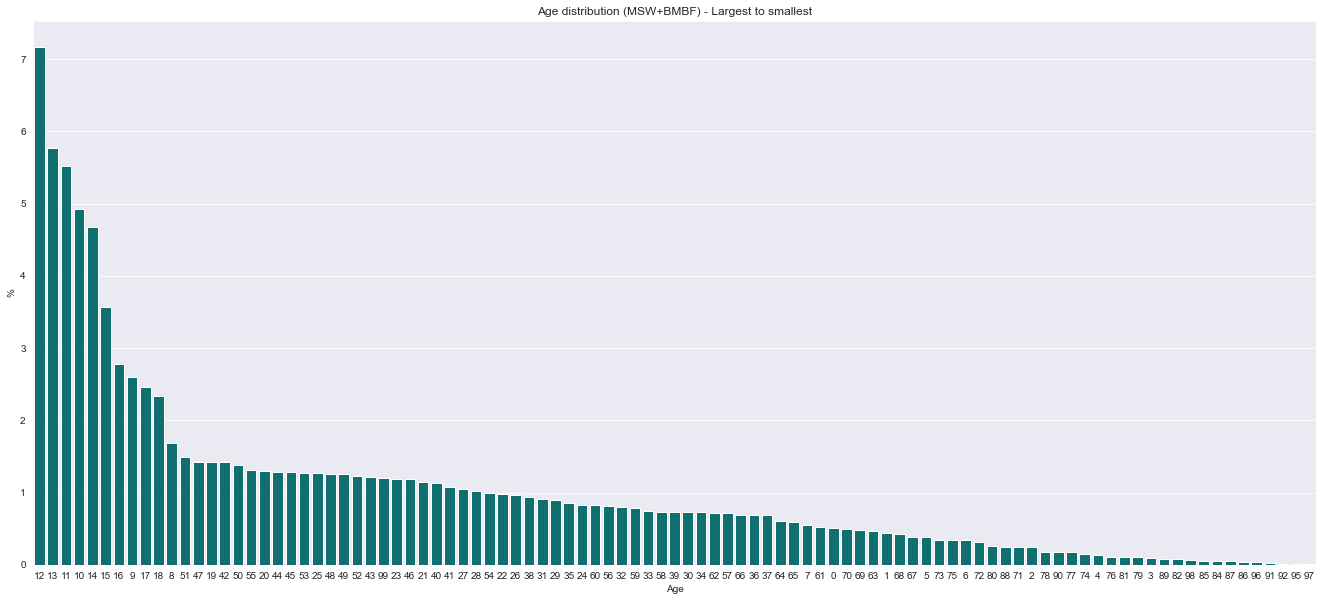

In [9]:
# normalize and get percentage
age_counts = parts.Age.value_counts(normalize=True).mul(100)
ages = age_counts.index.values

age_per = pd.DataFrame({"%": age_counts.values}, index=ages)
age_per.index.name = "Age"
display(age_per)

ax = sns.barplot(
    data=age_per,
    x=age_per.index,
    y="%",
    order=ages,
    color="teal"
)

ax.grid(False, axis="x")

plt.title("Age distribution (MSW+BMBF) - Largest to smallest")
plt.gcf().set_size_inches(23, 10)
plt.show()

__Gaze Definition__

Participants data

In [10]:
parts

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,file,created,condition,frames
uid,,,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-ec61bab6e46741...,10.03.2020 01:11,RadioTalk,3070
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,Path_ MS Wissenschaft-RadioTalk-1fbde03890d94b...,18.02.2020 16:24,RadioTalk,3070
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,Path_ MS Wissenschaft-RadioTalk-1ad9eea672a945...,09.03.2020 21:31,RadioTalk,3070
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,Path_ MS Wissenschaft-TaxiDriver-461b2d80132f4...,10.03.2020 02:40,TaxiDriver,3070
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-4f300efb4a9941...,09.03.2020 22:19,RadioTalk,3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,Path_ MS Wissenschaft-RadioTalk-eda9175e9e1d41...,24.01.2020 13:28,RadioTalk,3070
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-b8c9e625f0744...,24.01.2020 15:06,TaxiDriver,3070
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-2cd78ad9a37945...,24.01.2020 11:49,RadioTalk,3070


Select a participant to test Jasmine's Gaze definition (saccades and fixations differentiation)

In [11]:
# select first participant colliders file
file = parts.iloc[0].file  # get filename
part_col = pd.read_csv(f"./data/colliders/{file}", keep_default_na=False)

Get average framerate

In [12]:
first_frame = part_col.frameNumber.iloc[0]
last_frame = part_col.frameNumber.iloc[-1]

frame_diff = last_frame - first_frame
afps = frame_diff / 90
afps

29.666666666666668

Assuming constant framerate (sampling frequency, FPS), the sampling period (time distance between samples, in seconds)

In [13]:
asp = 1 / afps
asp

0.033707865168539325

From here on we follow this assumption. So we're going to use the latter average FPS (sampling frequency) and sampling period (1/SF).

In [14]:
# Every consecutive hitpoints between 0 and 100ms after
# a fixation/gaze (>=260-330ms) will be labeled as saccades
saccade_l = (0, 0.1)  # saccade length (<=100ms)
gaze_l = (0.26, 0.33)  # gaze length (min, max)

Given our SF/SP (≈29.67FPS/0.337s), how many hit points do we need to find a saccade and a gaze?

In [15]:
hp_saccade = 0.1 / asp
hp_saccade

2.966666666666667

A saccade shouldn't take at least 1-3 hit points

In [16]:
hp_gaze = (0.26 / asp, 0.33 / asp)
hp_gaze

(7.713333333333334, 9.790000000000001)

A gaze should at least have 7-10 hit points

Thus we will consider anything between 1 and 6 hitpoints a saccade and over 7 a gaze/fixation

In [17]:
part_col = pd.read_csv(f"./data/colliders/{parts.iloc[0].file}", keep_default_na=False)
part_col

,frameNumber,trackerPosition,trackerRotation,centerHit,centerHitPosition,centerHitGroup,boxHit,boxHitPosition,boxHitGroup,presentObjectName,presentObjectGroup
0,400,"(-193.8, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 108.8, -150.2)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 98.5, -135.4)",WestRide Traffic,Building01*Building 4*Building 3*TS1_Stand_Med...,WestRide Buildings*WestRide Buildings*WestRide...
1,401,"(-193.8, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 110.2, -149.6)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 98.8, -135.4)",WestRide Traffic,Building01*Building 4*Building 3*TS1_Stand_Med...,WestRide Buildings*WestRide Buildings*WestRide...
2,402,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 111.8, -147.6)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 99.2, -135.4)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
3,403,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 114.3, -143.0)",WestRide Buildings,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
4,404,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(62.3, 115.7, -137.6)",WestRide Buildings,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
...,...,...,...,...,...,...,...,...,...,...,...
2666,3066,"(-41.4, 102.3, -199.4)","(0.1, 0.8, 0.0, -0.6)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 103.6, -205.3)",WestRide Buildings,3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 100.1, -200.1)",WestRide Buildings,Building 4*Building 3*Circle_Sign_LOD0*TS1_Sta...,WestRide Buildings*WestRide Buildings*WestRide...
2667,3067,"(-41.7, 102.3, -199.4)","(0.1, 0.8, 0.0, -0.6)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 103.7, -204.8)",WestRide Buildings,3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 100.1, -200.1)",WestRide Buildings,Building 4*Building 3*TS1_Stand_Medium_LOD0*TS...,WestRide Buildings*WestRide Buildings*WestRide...
2668,3068,"(-41.9, 102.3, -199.4)","(0.1, 0.8, 0.0, -0.6)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 103.8, -204.5)",WestRide Buildings,3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 100.1, -200.1)",WestRide Buildings,Building 4*Building 3*Square_Sign_LOD0*TS1_Sta...,WestRide Buildings*WestRide Buildings*WestRide...
2669,3069,"(-42.1, 102.3, -199.4)","(0.1, 0.8, 0.0, -0.7)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 103.8, -204.1)",WestRide Buildings,3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 100.1, -200.1)",WestRide Buildings,Building 4*Building 3*Square_Sign_LOD0*TS1_Sta...,WestRide Buildings*WestRide Buildings*WestRide...


Process all participants counting and groupping consecutive hitpoints

In [34]:
# original function taken from: https://stackoverflow.com/a/39533085
# modified to return only acute angles in degrees
# def angle(v1, v2):
#     # v1 is your firsr vector
#     # v2 is your second vector
#     angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
#     return np.degrees(angle)

# rewritten for a better understanding
def angle(a, b):
    """
    Angle (in degrees) between two vectors.
    
    Given two 3D vectors (a and b):
    a = [xa, ya, za] , b = [xb, yb, zb]
    
    And the basic geometric formula for the dot product:
    a · b = |a| * |b| * cos(α) => α = arccos[(a · b) / (|a| * |b|)]
    
    In other words:
    angle = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]
    
    Source: https://www.omnicalculator.com/math/angle-between-two-vectors
    
    Parameters:
        a (numpy.array): First vector
        b (numpy.array): Second vector
    Returns:
        float: Angle between vectors a and b in degrees.
    """
    # a · b
    dotp = np.dot(a, b)
    
    # magnitude vectors |a| and |b|
    m_a = np.linalg.norm(a)
    m_b = np.linalg.norm(b)
    
    # |a| * |b|
    m_prod = m_a * m_b
    
    # (a * b) / (|a| * |b|)
    res = dotp / m_prod
    
    # α = arccos[(a · b) / (|a| * |b|)]
    angle = np.arccos(res)
    
    # calculated angle from radians to degrees
    return np.degrees(angle)


def check_consecutive(uid):
    """
    Process a participant hit-related information given an id.
    
    Compute the total of consecutive hits, nulls and store it into a shared-memory array.
    Also compute and store nose vectors, distances, and angles into a single participant csv file.
    
    Parameters:
        uid (str): Participant identifier.
    """
    
    # participant colliders filename
    file = parts.loc[uid].file
    # index of the participant to match the array row on the hits calculations
    idx = parts.index.get_loc(uid)
    part_col = pd.read_csv(f"./data/colliders/{file}", keep_default_na=False)
    
    # participant dict to fill out and generate the dataframe in the end
    participant = {
        # trackerPosition
        "x": [],
        "y": [],
        "z": [],
        # nose vector between trackerPosition and centerHit
        "centerVectorX": [],
        "centerVectorY": [],
        "centerVectorZ": [],
        # angle between consecutive center-based nose vectors 
        "centerAngle": [],
        # euclidean distance between centerHitPosition and trackerPosition
        "centerDistance": [],
        # euclidean distance between consecutive centerHitPositions
        "cObjectDistance": [],
        # nose vector between trackerPosition and boxHit
        "boxVectorX": [],
        "boxVectorY": [],
        "boxVectorZ": [],
        # angles between consecutive box-based nose vectors
        "boxAngle": [],
        # euclidean distance between boxHitPosition and trackerPosition
        "boxDistance": [],
        # euclidean distance between consecutive boxHitPositions
        "bObjectDistance": []
    }
    
    # create dicts to keep up with center and box hits counters:
    # bhit (boxHit), chit (centerHit), previous (p), current (c), next(n)
    bhit = {"p": None, "c": None, "n": None, "cnt": 0}
    chit = {"p": None, "c": None, "n": None, "cnt": 0}
    
    # initialize box and center nose vector and hitPosition temporary lists
    cvector = []
    bvector = []
    chitpos = []
    bhitpos = []
    for i in range(N):  # iterate over all samples (frames)
        # parse trackerPosition (x, y, z)
        x, y, z = part_col.iloc[i].trackerPosition.split("(")[1].split(")")[0].split(",")
        # store it
        participant["x"].append(x)
        participant["y"].append(y)
        participant["z"].append(z)

        # centerHit processing
        # ====================
        chit["p"] = chit["c"]
        chit["c"] = part_col.iloc[i].centerHit
        # because the comparison is between previous, current and next frame
        # and for the first frame the previous is anyways null (default initialized)
        if i + 1 < N:
            chit["n"] = part_col.iloc[i + 1].centerHit
        if chit["c"] != "null":  # current centerHit sample is not "null"
            # only if it is not null there is a hitPosition, otherwise (0, 0, 0)
            # hitPosition coordinates
            x1, y1, z1 = part_col.iloc[i].centerHitPosition.split("(")[1].split(")")[0].split(",")
            # origin -> nose vector starting point, end -> nose vector ending point
            origin = np.array([float(x), float(y), float(z)])
            end = np.array([float(x1), float(y1), float(z1)])
            # store consecutive hit positions on objects to calculates distances between them
            chitpos.append(end)
            # compute and store the nose vector for consecutive hits
            nose = end - origin  # same as np.subtract(end, origin)
            cvector.append(nose)
            # compute euclidean distance between origin and end points (nose vector)
            dist = np.linalg.norm(nose)
            participant["centerDistance"].append(dist)  # store it 
            # initialize to 1 if previous and current have different object names 
            # otherwise increment 
            chit["cnt"] = 1 if chit["p"] != chit["c"] else chit["cnt"] + 1
            # when no more consecutives (current and next are different)
            if chit["c"] != chit["n"] or i == N - 1:
                # increment the number of consecutive hits for the given participant
                chits[idx, chit["cnt"]] += 1
                if len(cvector) > 1:
                    for v in range(len(cvector)):
                        # store coordinates of consecutive nose vectors
                        participant["centerVectorX"].append(cvector[v][0])
                        participant["centerVectorY"].append(cvector[v][1])
                        participant["centerVectorZ"].append(cvector[v][2])
                        # add initial angle as 0 as always current - previous
                        if v == 0:
                            participant["centerAngle"].append(0.0)
                            participant["cObjectDistance"].append(0.0)
                        if v < len(cvector) - 1:
                            # select current and next vector
                            v0 = cvector[v]
                            v1 = cvector[v+1]
                            # (v0 == v1).all() same as np.array_equal(v0, v1)
                            # calculate the angle only if the vectors are different
                            an = 0.0 if (v0 == v1).all() else angle(v0, v1)
                            participant["centerAngle"].append(an)
                            h0 = chitpos[v]
                            h1 = chitpos[v+1]
                            # calculate the hit distance only if the coordinates are different
                            di = 0.0 if (h0 == h1).all() else np.linalg.norm(h0 - h1)  # same as h1 - h0
                            participant["cObjectDistance"].append(di)

                else:
                    # in case of 1 hit, store the nose vector and the rest as zeros (avoid NaNs) 
                    participant["centerVectorX"].append(cvector[0][0])
                    participant["centerVectorY"].append(cvector[0][1])
                    participant["centerVectorZ"].append(cvector[0][2])
                    participant["centerAngle"].append(0.0)
                    participant["cObjectDistance"].append(0.0)
                # reset consecutive counter and temporary nose vector lists
                chit["cnt"] = 0
                cvector = []
                chitpos = []
        else:
            # increment the number of consecutive hits for the given participant
            chits[idx, 0] += 1
            # store non-existing nose vector as (0, 0, 0) to avoid NaNs
            participant["centerVectorX"].append(0.0)
            participant["centerVectorY"].append(0.0)
            participant["centerVectorZ"].append(0.0)
            participant["centerAngle"].append(0.0)
            participant["centerDistance"].append(0.0)
            participant["cObjectDistance"].append(0.0)
            # reset consecutive counter and current object name
            chit["cnt"] = 0
            chit["c"] = None
            # reset consecutive counter and temporary nose vector lists
            cvector = []
            chitpos = []
            
        # boxHit processing
        # =================
        bhit["p"] = bhit["c"]
        bhit["c"] = part_col.iloc[i].boxHit
        # because the comparison is between previous, current and next frame
        # and for the first frame the previous is anyways null (default initialized)
        if i + 1 < N:
            bhit["n"] = part_col.iloc[i + 1].boxHit
        if bhit["c"] != "null":  # current boxHit sample is not "null"
            # only if it is not null there is a hitPosition, otherwise (0, 0, 0)
            # boxPosition coordinates
            x1, y1, z1 = part_col.iloc[i].boxHitPosition.split("(")[1].split(")")[0].split(",")
            # origin -> nose vector starting point, end -> nose vector ending point
            origin = np.array([float(x), float(y), float(z)])
            end = np.array([float(x1), float(y1), float(z1)])
            # store consecutive hit positions on objects to calculates distances between them
            bhitpos.append(end)
            # compute and store the nose vector for consecutive hits
            nose = end - origin  # same as np.subtract(end, origin)
            bvector.append(nose)
            # compute euclidean distance between origin and end points (nose vector)
            dist = np.linalg.norm(nose)
            participant["boxDistance"].append(dist)  # store it 
            # initialize to 1 if previous and current have different object names 
            # otherwise increment 
            bhit["cnt"] = 1 if bhit["p"] != bhit["c"] else bhit["cnt"] + 1
            # when no more consecutives (current and next are different)
            if bhit["c"] != bhit["n"] or i == N - 1:
                # increment the number of consecutive hits for the given participant
                bhits[idx, bhit["cnt"]] += 1
                if len(bvector) > 1:
                    for v in range(len(bvector)):
                        # store coordinates of consecutive nose vectors
                        participant["boxVectorX"].append(bvector[v][0])
                        participant["boxVectorY"].append(bvector[v][1])
                        participant["boxVectorZ"].append(bvector[v][2])
                        # add initial angle as 0 as always current - previous
                        if v == 0:
                            participant["boxAngle"].append(0.0)
                            participant["bObjectDistance"].append(0.0)
                        if v < len(bvector) - 1:
                            # select current and next vector
                            v0 = bvector[v]
                            v1 = bvector[v+1]
                            # (v0 == v1).all() same as np.array_equal(v0, v1)
                            # calculate the angle only if the vectors are different
                            an = 0.0 if (v0 == v1).all() else angle(v0, v1)
                            participant["boxAngle"].append(an)
                            h0 = bhitpos[v]
                            h1 = bhitpos[v+1]
                            # calculate the hit distance only if the coordinates are different
                            di = 0.0 if (h0 == h1).all() else np.linalg.norm(h0 - h1)  # same as h1 - h0
                            participant["bObjectDistance"].append(di)

                else:
                    # in case of 1 hit, store the nose vector and the rest as zeros (avoid NaNs) 
                    participant["boxVectorX"].append(bvector[0][0])
                    participant["boxVectorY"].append(bvector[0][1])
                    participant["boxVectorZ"].append(bvector[0][2])
                    participant["boxAngle"].append(0.0)
                    participant["bObjectDistance"].append(0.0)
                # reset consecutive counter and temporary nose vector lists
                bhit["cnt"] = 0
                bvector = []
                bhitpos = []
        else:
            # increment the number of consecutive hits for the given participant
            bhits[idx, 0] += 1
            # store non-existing nose vector as (0, 0, 0) to avoid NaNs
            participant["boxVectorX"].append(0.0)
            participant["boxVectorY"].append(0.0)
            participant["boxVectorZ"].append(0.0)
            participant["boxAngle"].append(0.0)
            participant["boxDistance"].append(0.0)
            participant["bObjectDistance"].append(0.0)
            # reset consecutive counter and current object name
            bhit["cnt"] = 0
            bhit["c"] = None
            # reset consecutive counter and temporary nose vector lists
            bvector = []
            bhitpos = []

    part = pd.DataFrame(participant)
    include = part_col[["frameNumber", "centerHit", "centerHitGroup", "boxHit", "boxHitGroup"]]
    part = part.join(include)
    # store participant processed data as csv
    part.to_csv(f"./data/hits/{file}", index=False)
    


# test = None
# participants (using a generator because it should be faster than a list here)
uids = (uid for uid in parts.index.to_list()[:1])
uids_len = len(parts.index.to_list()[:1])

# since the experiment lasts 90 seconds
# the maximum, although not really possible, n_samples
# looking at the same object/spot would be 90s * 30FPS = 2700
# but the index size of each participant it's actually 2671
N = part_col.index.size

# duplicate array (for box and center hits)
# shared memory Array(ctype_or_ctype_code, size or initializer)
# only 1D arrays allowed, it will create an array of uids_len x N of zeros
chits = RawArray("i", uids_len * N)
bhits = RawArray("i", uids_len * N)
# each row (imaginary) will represent the consecutive hits computed per participant
# thus we wrap it as a numpy array for [row, col] slicing and indexing convenience
chits = np.frombuffer(chits, dtype=np.int32).reshape((uids_len, N))
bhits = np.frombuffer(bhits, dtype=np.int32).reshape((uids_len, N))

pool = Pool(processes=1)

# progress bar format definitons
m_format = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar}
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} 📅{eta:%d/%m/%y}
             🕒{eta:%H:%M}"""

# participants progress bar
parts_progress = tqdm(
    iterable=pool.imap_unordered(func=check_consecutive, iterable=uids),
    total=uids_len,
    desc="📂 participants",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_progress:
    pass

pool.close()
pool.join()
parts_progress.close()

📄 0 of 1 📂 participants processed:           
              0% ⏱️00:00 ⏳? 📅01/01/70
             🕒00:00

In [28]:
test

Parse the consecutive hits calculations (arrays `chits` and `bhits`) as a dataframe

In [49]:
cols = [i for i in range(N)]  # generate cols (0-2700)
cols.insert(0, "hitType")
cols.insert(0, "uid")
df_hits = pd.DataFrame(columns=cols)

progress = tqdm(iterable=parts.index.to_list()[:500])
hits = {i: [] for i in range(N)}
hits["uid"] = []
hits["hitType"] = []
for idx, part in enumerate(progress):
    [hits[i].append(chits[idx, i]) for i in range(N)]
    [hits[i].append(bhits[idx, i]) for i in range(N)]
    hits["uid"].append(part)
    hits["hitType"].append("center")
    hits["uid"].append(part)
    hits["hitType"].append("box")

df_hits = df_hits.append(pd.DataFrame(hits), ignore_index=True)

df_hits

  0%|          | 0/500 [00:00<?, ?it/s]

,uid,hitType,0,1,2,3,4,5,6,7,...,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670
0,ec61bab6e46741969bceb80ee2246983,center,833,45,15,8,9,12,2,4,...,0,0,0,0,0,0,0,0,0,0
1,ec61bab6e46741969bceb80ee2246983,box,690,66,25,14,15,11,8,11,...,0,0,0,0,0,0,0,0,0,0
2,1fbde03890d94bddaf7aa987fc732607,center,2526,15,7,0,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1fbde03890d94bddaf7aa987fc732607,box,1082,43,11,11,13,9,8,6,...,0,0,0,0,0,0,0,0,0,0
4,1ad9eea672a94518b150925bac41fcbc,center,600,62,31,13,12,9,2,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5681785cab654d408af1a4af7a763ab8,box,356,78,43,32,20,13,16,6,...,0,0,0,0,0,0,0,0,0,0
996,0f1556e02ea549a696223d32e3770349,center,1085,39,9,7,3,4,4,6,...,0,0,0,0,0,0,0,0,0,0
997,0f1556e02ea549a696223d32e3770349,box,184,39,22,11,15,5,5,3,...,0,0,0,0,0,0,0,0,0,0
998,f2febc5e0ea543589185dbd95eb946c3,center,346,40,29,11,11,10,6,7,...,0,0,0,0,0,0,0,0,0,0


Get rid of columns with only zeros (no consecutive hits) from right (biggest) to left (smallest) until first non-zero encountered

In [50]:
cols = df_hits.columns.to_list()  # get cols of df
cols.reverse()  # reverse the order of the columns

progress = tqdm(iterable=cols)  # prepare progressbar
for col in progress:  # iterate over df columns
    # drop column if sum is zero, otherwise stop iterating
    if df_hits[col].sum() == 0:
        df_hits = df_hits.drop(col, axis=1)
    else:
        break

# store as csv and display
df_hits.to_csv("./data/consecutive_hits.csv", index=False)
df_hits

  0%|          | 0/2673 [00:00<?, ?it/s]

,uid,hitType,0,1,2,3,4,5,6,7,...,616,617,618,619,620,621,622,623,624,625
0,ec61bab6e46741969bceb80ee2246983,center,833,45,15,8,9,12,2,4,...,0,0,0,0,0,0,0,0,0,0
1,ec61bab6e46741969bceb80ee2246983,box,690,66,25,14,15,11,8,11,...,0,0,0,0,0,0,0,0,0,0
2,1fbde03890d94bddaf7aa987fc732607,center,2526,15,7,0,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1fbde03890d94bddaf7aa987fc732607,box,1082,43,11,11,13,9,8,6,...,0,0,0,0,0,0,0,0,0,0
4,1ad9eea672a94518b150925bac41fcbc,center,600,62,31,13,12,9,2,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5681785cab654d408af1a4af7a763ab8,box,356,78,43,32,20,13,16,6,...,0,0,0,0,0,0,0,0,0,0
996,0f1556e02ea549a696223d32e3770349,center,1085,39,9,7,3,4,4,6,...,0,0,0,0,0,0,0,0,0,0
997,0f1556e02ea549a696223d32e3770349,box,184,39,22,11,15,5,5,3,...,0,0,0,0,0,0,0,0,0,0
998,f2febc5e0ea543589185dbd95eb946c3,center,346,40,29,11,11,10,6,7,...,0,0,0,0,0,0,0,0,0,0


14.025

It takes more than 2,5 hours to process everything...

-> TODO:

- [ ] Apply multithreading. Processing time shoud be reduced up to 12-15 minutes.

In [ ]:
# range(2700) -> range(1, 2700) fix
# df_hits = df_hits.drop(["b-0", "c-0"], axis=1)
df_hits

Reorder columns (iterleave b and c columns)

In [ ]:
# TODO: apply this fix on the DataFrame generation once multithreading is included
cols = [f"{l}-{i}" for i in range(1, 2700) for l in ["b", "c"]]
cols = ["b-null", "c-null"] + cols  # concatenate/add before cols' start
df_hits = df_hits[cols]
df_hits

Remove all columns with 0 values starting from the last one, until one != 0 is found (removed unnused).

In [ ]:
cols_rev = copy.deepcopy(cols)
cols_rev.reverse()
cols_rev_it = itertools.cycle(cols_rev)

zeros_col = True
while(zeros_col):
    column = next(cols_rev_it)
    if column in df_hits.columns:
        if df_hits[column].sum() == 0:
            df_hits.drop(column, axis=1, inplace=True)
        else:
            zeros_col = False  # same as break

In [ ]:
df_hits

In [ ]:
df_hits.to_csv("./data/consecutive_hits.csv")

In [64]:
# without index_col=0 (default None), generates an index instead of using the first column
hits_df = pd.read_csv("./data/consecutive_hits.csv", keep_default_na=False, index_col=0)
hits_df

,b-null,c-null,b-1,c-1,b-2,c-2,b-3,c-3,b-4,c-4,...,b-667,c-667,b-668,c-668,b-669,c-669,b-670,c-670,b-671,c-671
uid,,,,,,,,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,690,833,66,45,25,15,14,8,15,9,...,0,0,0,0,0,0,0,0,0,0
1fbde03890d94bddaf7aa987fc732607,1082,2526,43,15,11,7,11,0,13,2,...,0,0,0,0,0,0,0,0,0,0
1ad9eea672a94518b150925bac41fcbc,106,600,70,62,29,31,29,13,16,12,...,0,0,0,0,0,0,0,0,0,0
461b2d80132f47958e50003c16084cf4,101,1929,44,23,23,9,19,2,10,5,...,0,0,0,0,0,0,0,0,0,0
4f300efb4a9941f7a96f57e8030b12e2,185,2648,17,7,12,1,2,1,8,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,465,1343,68,90,33,25,23,18,13,17,...,0,0,0,0,0,0,0,0,0,0
b8c9e625f07444cc8d4a0fc245bab5dd,193,1156,60,53,24,21,20,9,12,9,...,0,0,0,0,0,0,0,0,0,0
2cd78ad9a37945de9f8cfd5f81c42082,536,2381,62,43,43,10,28,2,16,4,...,0,0,0,0,0,0,0,0,0,0


Nulls vs apparent saccades and apparent gazes

In [65]:
# participants
uids = parts.index
# progress bar format definitons
m_format = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar}
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} 📅{eta:%d/%m/%y}
             🕒{eta:%H:%M}"""

# cs progress bar
parts_progress = tqdm(
    uids,
    desc="📂 participants",
    dynamic_ncols=False,
    ncols=None,  # "100%" breaks the pbar
    mininterval=0.001,
    bar_format=m_format,
)

nsg_comp = pd.DataFrame(columns=["b-null", "c-null", "b-saccades", "c-saccades", "b-gazes", "c-gazes"], index=hits_df.index)
nsg_perc = copy.deepcopy(nsg_comp)
b_cols = hits_df.filter(like="b").columns
c_cols = hits_df.filter(like="c").columns
bcols = nsg_comp.filter(like="b-").columns
ccols = nsg_comp.filter(like="c-").columns
for uid in parts_progress:
    nsg_comp.loc[uid]["b-null"] = hits_df.loc[uid][b_cols[0]]
    nsg_comp.loc[uid]["c-null"] = hits_df.loc[uid][c_cols[0]]
    nsg_comp.loc[uid]["b-saccades"] = hits_df.loc[uid][b_cols[1:7]].sum()
    nsg_comp.loc[uid]["c-saccades"] = hits_df.loc[uid][c_cols[1:7]].sum()
    nsg_comp.loc[uid]["b-gazes"] = hits_df.loc[uid][b_cols[7:len(b_cols)]].sum()
    nsg_comp.loc[uid]["c-gazes"] = hits_df.loc[uid][c_cols[7:len(c_cols)]].sum()
    # turn into percentages
    btotal = nsg_comp.loc[uid][bcols].sum()
    ctotal = nsg_comp.loc[uid][ccols].sum()
    for col in bcols:
        nsg_perc.loc[uid][col] = nsg_comp.loc[uid][col] * 100 / btotal
    for col in ccols:
        nsg_perc.loc[uid][col] = nsg_comp.loc[uid][col] * 100 / ctotal

📄 0 of 7913 📂 participants processed:           
              0% ⏱️00:00 ⏳? 📅01/01/70
             🕒00:00

In [66]:
nsg_comp

,b-null,c-null,b-saccades,c-saccades,b-gazes,c-gazes
uid,,,,,,
ec61bab6e46741969bceb80ee2246983,690,833,139,91,74,43
1fbde03890d94bddaf7aa987fc732607,1082,2526,95,25,76,7
1ad9eea672a94518b150925bac41fcbc,106,600,177,129,108,51
461b2d80132f47958e50003c16084cf4,101,1929,114,49,101,24
4f300efb4a9941f7a96f57e8030b12e2,185,2648,50,11,95,0
...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,465,1343,168,166,108,43
b8c9e625f07444cc8d4a0fc245bab5dd,193,1156,145,104,107,44
2cd78ad9a37945de9f8cfd5f81c42082,536,2381,180,69,101,13


In [67]:
nsg_comp = nsg_comp.astype("int32")
nsg_comp.describe()

,b-null,c-null,b-saccades,c-saccades,b-gazes,c-gazes
count,7913.00,7913.00,7913.00,7913.00,7913.00,7913.00
mean,385.06,1369.52,139.38,95.99,94.83,38.42
std,382.60,793.69,51.15,69.10,14.90,22.57
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,101.00,685.00,101.00,37.00,87.00,19.00
50%,262.00,1225.00,136.00,89.00,97.00,41.00
75%,552.00,2119.00,173.00,144.00,105.00,56.00
max,2670.00,2670.00,407.00,395.00,132.00,105.00


In [68]:
nsg_perc

,b-null,c-null,b-saccades,c-saccades,b-gazes,c-gazes
uid,,,,,,
ec61bab6e46741969bceb80ee2246983,76.41,86.14,15.39,9.41,8.19,4.45
1fbde03890d94bddaf7aa987fc732607,86.35,98.75,7.58,0.98,6.07,0.27
1ad9eea672a94518b150925bac41fcbc,27.11,76.92,45.27,16.54,27.62,6.54
461b2d80132f47958e50003c16084cf4,31.96,96.35,36.08,2.45,31.96,1.20
4f300efb4a9941f7a96f57e8030b12e2,56.06,99.59,15.15,0.41,28.79,0.00
...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,62.75,86.53,22.67,10.70,14.57,2.77
b8c9e625f07444cc8d4a0fc245bab5dd,43.37,88.65,32.58,7.98,24.04,3.37
2cd78ad9a37945de9f8cfd5f81c42082,65.61,96.67,22.03,2.80,12.36,0.53


In [69]:
nsg_perc = nsg_perc.astype("float")
nsg_perc.describe()

,b-null,c-null,b-saccades,c-saccades,b-gazes,c-gazes
count,7913.00,7913.00,7913.00,7913.00,7913.00,7913.00
mean,48.97,85.64,29.43,9.86,21.60,4.50
std,26.40,14.06,15.18,9.86,12.71,4.76
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,28.54,79.23,16.96,2.12,11.63,0.89
50%,51.24,89.36,28.73,7.18,19.32,3.23
75%,70.65,96.62,41.32,14.35,29.56,6.56
max,100.00,100.00,72.16,72.03,67.15,43.46


Check population vs nulls relation in percentages

,box,center
% null,,
1,95.84,99.99
2,95.06,99.96
3,94.31,99.96
4,93.49,99.96
5,92.85,99.96
...,...,...
96,0.19,27.69
97,0.05,23.40
98,0.04,18.46


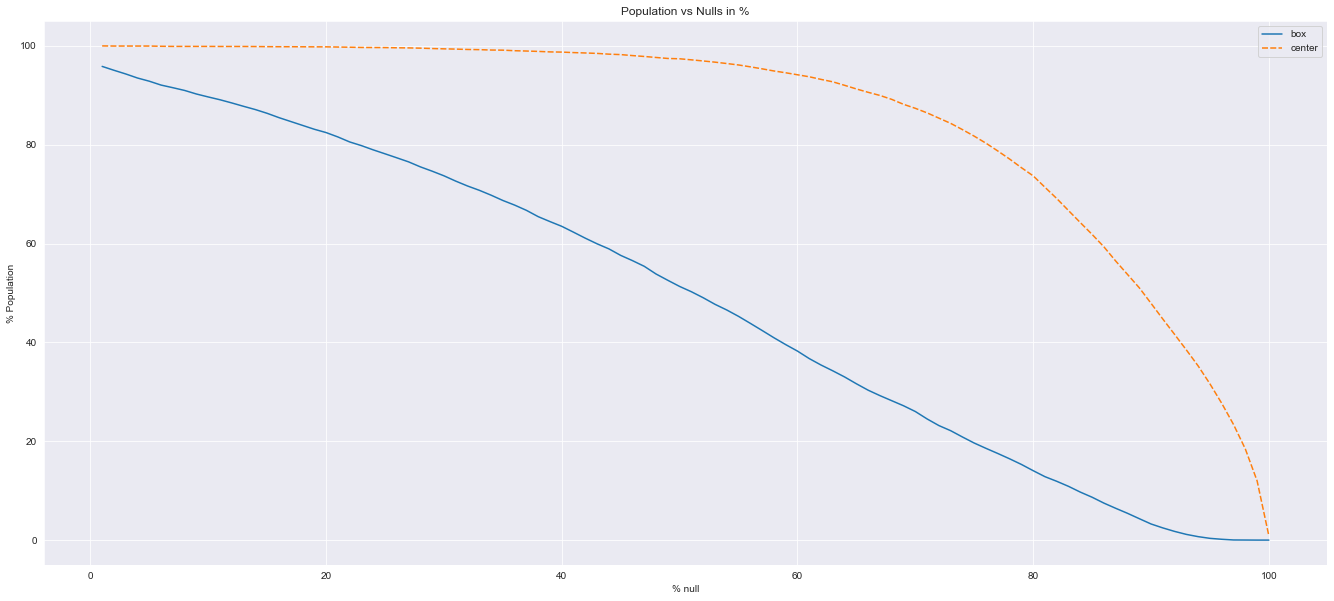

In [70]:
percentages = [i + 1 for i in range(100)]
percentages
null_per = pd.DataFrame(columns=["box", "center"], index=percentages)
null_per.index.name = "% null"
total = nsg_perc.index.size

for htyp in null_per.columns:
    for p in percentages:
        count = nsg_perc[nsg_perc[f"{htyp[0]}-null"] >= p].index.size
        null_per.loc[p][htyp] = count * 100 / total
null_per = null_per.astype("float")
display(null_per)

ax = sns.lineplot(data=null_per)
ax.set_ylabel("% Population")

plt.title("Population vs Nulls in %")
plt.gcf().set_size_inches(23, 10)
plt.show()

Check saccades and gazes vs population

,b-saccades,c-saccades,b-gazes,c-gazes
%,,,,
1,99.96,83.87,99.91,73.22
2,99.92,75.77,99.58,61.54
3,99.30,69.86,98.67,52.00
4,98.31,64.78,97.17,42.90
5,96.88,59.43,95.19,34.70
...,...,...,...,...
96,0.00,0.00,0.00,0.00
97,0.00,0.00,0.00,0.00
98,0.00,0.00,0.00,0.00


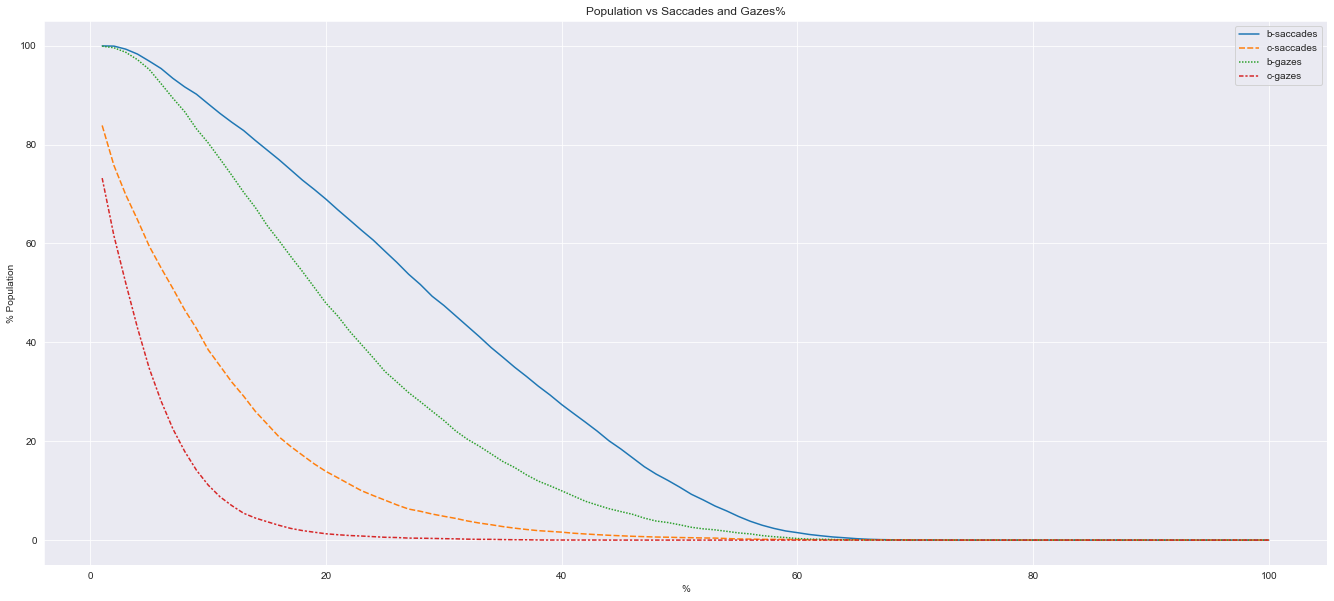

In [71]:
percentages = [i + 1 for i in range(100)]
percentages
sg_per = pd.DataFrame(columns=["b-saccades", "c-saccades", "b-gazes", "c-gazes"], index=percentages)
sg_per.index.name = "%"
total = nsg_perc.index.size

for col in sg_per.columns:
    for p in percentages:
        count = nsg_perc[nsg_perc[col] >= p].index.size
        sg_per.loc[p][col] = count * 100 / total
sg_per = sg_per.astype("float")        
display(sg_per)

ax = sns.lineplot(data=sg_per)
ax.set_ylabel("% Population")

plt.title("Population vs Saccades and Gazes%")
plt.gcf().set_size_inches(23, 10)
plt.show()

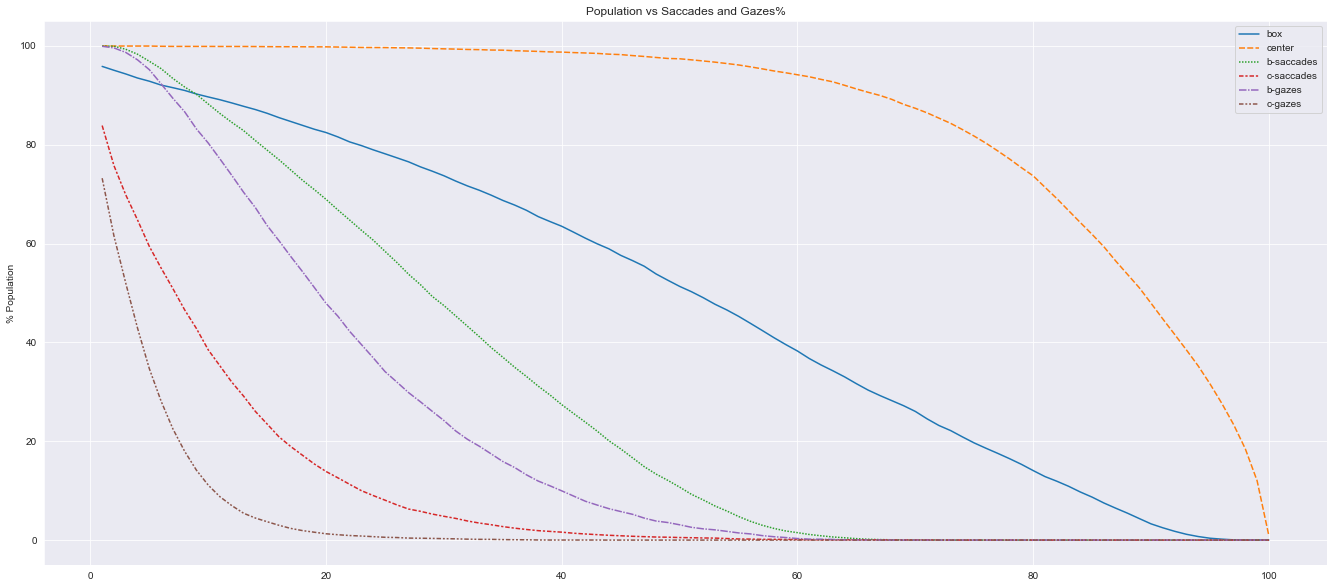

In [72]:
combined_per = pd.concat([null_per, sg_per])
ax = sns.lineplot(data=combined_per)
ax.set_ylabel("% Population")

plt.title("Population vs Saccades and Gazes%")
plt.gcf().set_size_inches(23, 10)
plt.show()

In [75]:
display(nsg_perc)
bcols = nsg_perc.filter(like="b-").columns
ccols = nsg_perc.filter(like="c-").columns
bren = {col: col.split("-")[1] for col in bcols}
cren = {col: col.split("-")[1] for col in ccols}
                 
nsg = copy.deepcopy(nsg_perc[bcols]).reset_index()
nsg = nsg.rename(columns=bren)
nsg_c = copy.deepcopy(nsg_perc[ccols]).reset_index()
nsg_c = nsg_c.rename(columns=cren)
nsg["hit"] = "center"
nsg_c["hit"] = "box"

nsg = pd.concat([nsg, nsg_c])
display(nsg)

ax = sns.catplot(data=nsg, kind="bar", x="hit")
# ax = sns.catplot(data=cmean, kind="bar")
# ax.set_ylabel("%")

plt.title("Population vs Saccades vs Gazes distribution")
plt.gcf().set_size_inches(23, 10)
plt.show()

,b-null,c-null,b-saccades,c-saccades,b-gazes,c-gazes
uid,,,,,,
ec61bab6e46741969bceb80ee2246983,76.41,86.14,15.39,9.41,8.19,4.45
1fbde03890d94bddaf7aa987fc732607,86.35,98.75,7.58,0.98,6.07,0.27
1ad9eea672a94518b150925bac41fcbc,27.11,76.92,45.27,16.54,27.62,6.54
461b2d80132f47958e50003c16084cf4,31.96,96.35,36.08,2.45,31.96,1.20
4f300efb4a9941f7a96f57e8030b12e2,56.06,99.59,15.15,0.41,28.79,0.00
...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,62.75,86.53,22.67,10.70,14.57,2.77
b8c9e625f07444cc8d4a0fc245bab5dd,43.37,88.65,32.58,7.98,24.04,3.37
2cd78ad9a37945de9f8cfd5f81c42082,65.61,96.67,22.03,2.80,12.36,0.53


,uid,null,saccades,gazes,hit
0,ec61bab6e46741969bceb80ee2246983,76.41,15.39,8.19,center
1,1fbde03890d94bddaf7aa987fc732607,86.35,7.58,6.07,center
2,1ad9eea672a94518b150925bac41fcbc,27.11,45.27,27.62,center
3,461b2d80132f47958e50003c16084cf4,31.96,36.08,31.96,center
4,4f300efb4a9941f7a96f57e8030b12e2,56.06,15.15,28.79,center
...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,86.53,10.70,2.77,box
7909,b8c9e625f07444cc8d4a0fc245bab5dd,88.65,7.98,3.37,box
7910,2cd78ad9a37945de9f8cfd5f81c42082,96.67,2.80,0.53,box
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,91.40,2.31,6.29,box


ValueError: Cannot use `hue` without `x` and `y`

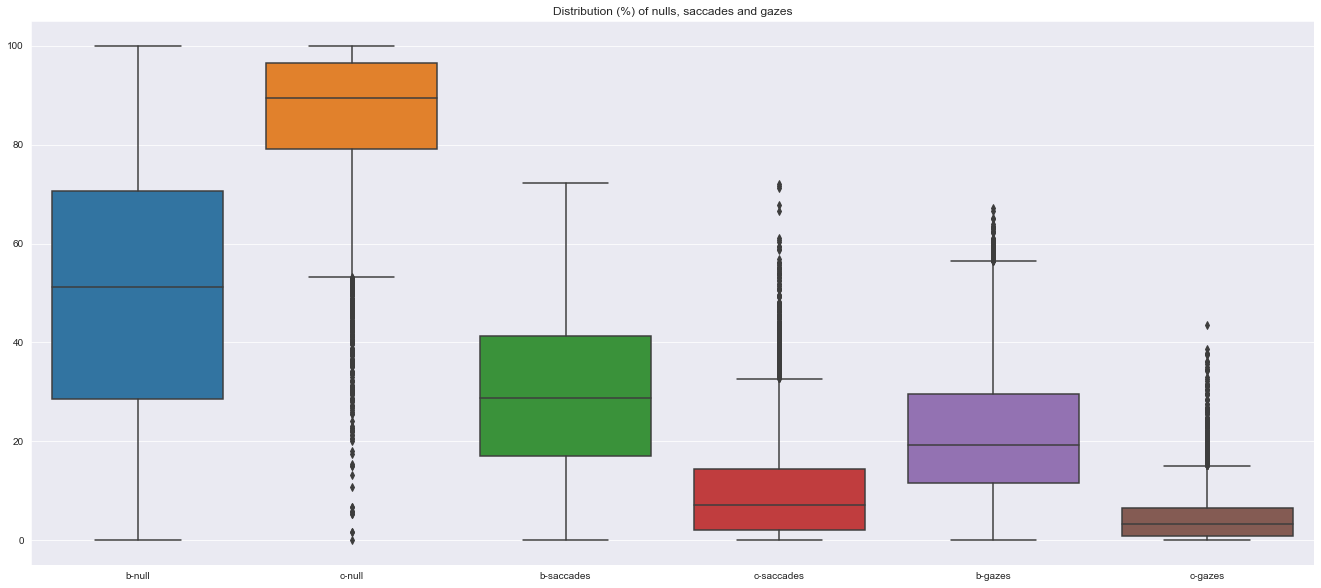

In [76]:
ax = sns.boxplot(data=nsg_perc)
# ax.set_ylabel("% Population")

plt.title("Distribution (%) of nulls, saccades and gazes")
plt.gcf().set_size_inches(23, 10)
plt.show()

How many participants have hits larger than 10s?

In [80]:

# participants
uids = parts.index

# column index to start looking for consecutive hp > 10s
threshold = 296  # 296 * asp = 9.978s

bcols = hits_df.filter(like="b-").columns
ccols = hits_df.filter(like="c-").columns

# progress bar format definitons
m_format = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar}
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} 📅{eta:%d/%m/%y}
             🕒{eta:%H:%M}"""

# cs progress bar
parts_progress = tqdm(
    uids,
    desc="📂 participants",
    dynamic_ncols=False,
    ncols=None,  # "100%" breaks the pbar
    mininterval=0.001,
    bar_format=m_format,
)

def check_participant(uid):
    for col in bcols[threshold:len(bcols)]:
        if hits_df.loc[uid][col] != 0:
            bout.append(uid)
            break
    for col in ccols[threshold:len(ccols)]:
        if hits_df.loc[uid][col] != 0:
            cout.append(uid)
            break

manager = Manager()
bout = manager.list()
cout = manager.list()
pool = Pool(processes=cores)
pool.imap(check_participant, parts_progress)
pool.close()

📄 0 of 7913 📂 participants processed:           
              0% ⏱️00:00 ⏳? 📅01/01/70
             🕒00:00

In [ ]:
150 * asp

Outliers

In [81]:
print("Box:")
print(len(bout))
# display(list(bout))
print("Center:")
print(len(cout))
# display(list(cout))

Box:
1
Center:
1102


In [82]:
# for col in nsg_perc.columns:
#     display(nsg_perc[col].value_counts())
display(pd.DataFrame(nsg_perc["b-null"].value_counts()).sort_index())
display(pd.DataFrame(nsg_perc["c-null"].value_counts()).sort_index())

,b-null
0.00,261
0.28,1
0.30,1
0.32,1
0.34,1
...,...
96.52,1
96.58,1
97.34,1
98.45,1


,c-null
0.00,1
1.57,1
1.71,1
5.23,1
5.36,1
...,...
99.96,6
99.96,8
99.96,8
99.96,11


Detect outliers (participants that removed their HMDs but the experiment kept running)

In [83]:
cols_time = []

In [84]:
# gs_dist = {key * asp: value for key, value in gs_dist.items() if value != 0}

In [85]:
cols = [f"{l}-{i}" for i in range(10) for l in ["b", "c"]]
cols.append("b-null")
cols.append("c-null")
sample = df_hits.head(10)[cols]
display(sample)

# display(sample.columns)
for c in cols:
    ax = sns.barplot(
        data=sample,
        x=c,
        y=sample[c].values,
#         hue=sample.index,
#         color="teal"
#         order=cols
    )

ax.grid(False, axis="x")
ax.margins(x=0)

plt.title("Frequency of the length of consecutive hits")
plt.gcf().set_size_inches(23, 10)
plt.show()

KeyError: "['b-0', 'c-0'] not in index"

Group data for an easier visualization and understanding

In [86]:
count_accum = 0
gdist_group = {}
bins = 0
gaze_or_not = {}
no_gaze = 0
gaze = 0
for key, value in gs_dist.items():
    if key <= 0.34:
        gdist_group[f"{key:.3f}"] = value
    else:
        count_accum += value
        bins += 1
    if key < 0.237:
        no_gaze += value
    else:
        gaze += value

gaze_or_not["saccade"] = no_gaze
gaze_or_not["gaze"] = gaze
gdist_group[">0.33"] = count_accum
print(f"Bins on >0.33: {bins}")
gdist_group

NameError: name 'gs_dist' is not defined

{}

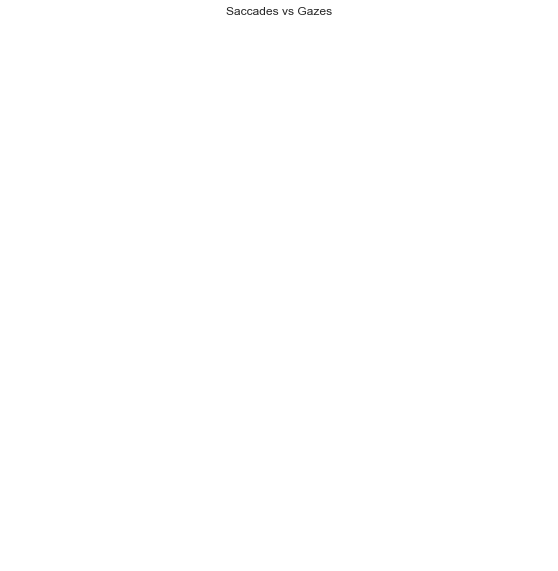

In [87]:
display(gaze_or_not)
plt.pie(gaze_or_not.values(), labels=gaze_or_not.keys(), autopct='%1.1f%%')
plt.title("Saccades vs Gazes")
plt.gcf().set_size_inches(23, 10)
plt.show()

In [88]:
df_gdist = pd.DataFrame(gdist_group, index=["count"]).transpose()
display(df_gdist)

# does not work
# ax = sns.histplot(
#     data=df_gdist,
#     x=df_gdist.index,
#     y="count",
#     kde=True,
#     discrete=True,
#     element="bars",
#     stat="density",
# )


# clrs = ["blue" if x <= 0.100 else "green" for x in df_gdist.index.values]

ax = sns.barplot(
    data=df_gdist,
    x=df_gdist.index,
    y="count",
    color="teal"
)

# xticks = [a for a in range(25)]
# ax.set(xticks=xticks, xticklabels=xticks)
ax.grid(False, axis="x")
ax.margins(x=0)

plt.title("Frequency of the length of consecutive hits")
plt.gcf().set_size_inches(23, 10)
plt.show()

,count


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

,count


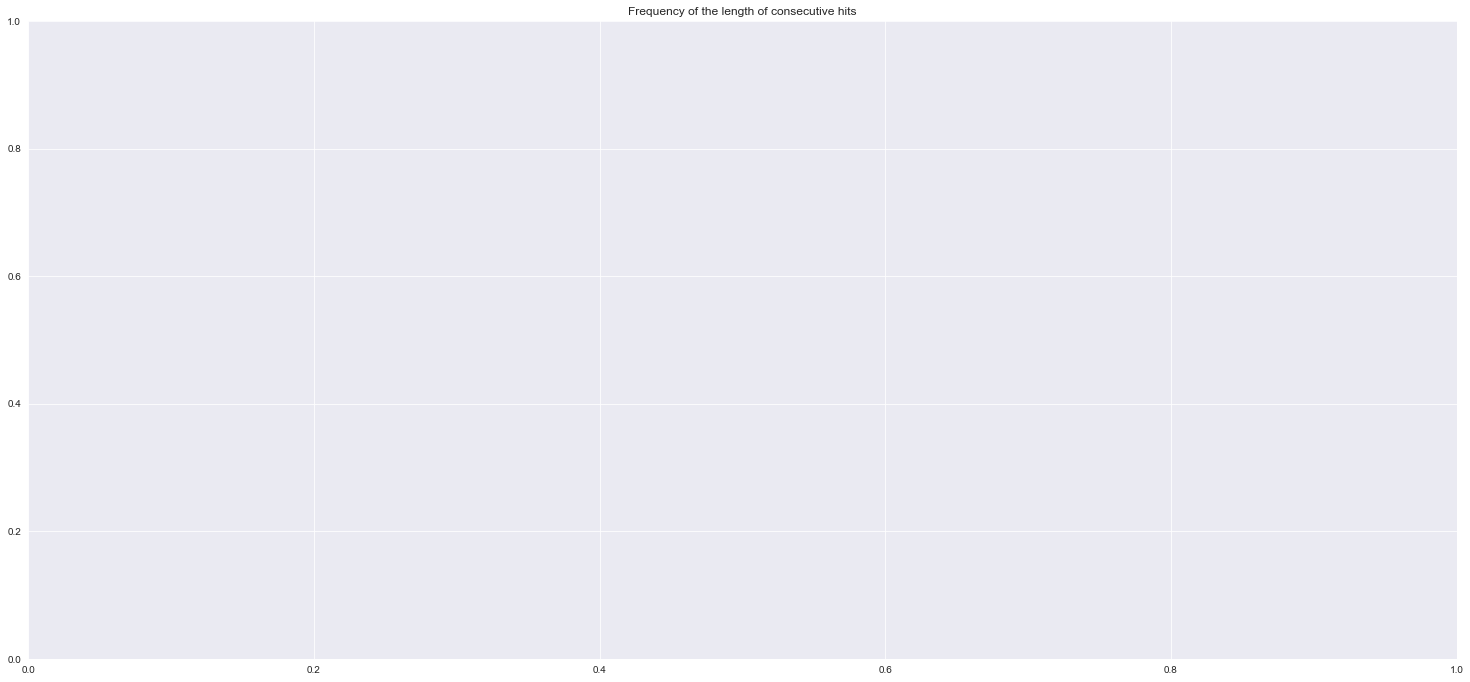

In [89]:
df_gdist = pd.DataFrame(gdist_group, index=["count"]).transpose()
display(df_gdist)

# does not work
ax = sns.displot(
    data=df_gdist,
    x=df_gdist.index,
    y="count",
    kind="hist",
    discrete=True,
    stat="density",
)


# clrs = ["blue" if x <= 0.100 else "green" for x in df_gdist.index.values]

# ax = sns.barplot(
#     data=df_gdist,
#     x=df_gdist.index,
#     y="count",
#     color="teal"
# )

# xticks = [a for a in range(25)]
# ax.set(xticks=xticks, xticklabels=xticks)
# ax.grid(False, axis="x")
# ax.margins(x=0)

plt.title("Frequency of the length of consecutive hits")
plt.gcf().set_size_inches(23, 10)
plt.show()

__Hit Group exploration__

_Center Hit Group_

Unique center hit group values

In [90]:
display(list(part_col.centerHitGroup.unique()))

['WestRide Buildings',
 'null',
 'WestRide Traffic',
 'PedestriansManager',
 'CarsManager']

Unique center hit group value counts (%)

In [91]:
chg_counts = part_col.centerHitGroup.value_counts(normalize=True) * 100
chg_vals = chg_counts.index.values

chg_per = pd.DataFrame({"%": chg_counts.values}, index=chg_vals)
chg_per.index.name = "CenterHitGroup"
display(chg_per)

,%
CenterHitGroup,
WestRide Buildings,65.22
null,31.19
WestRide Traffic,1.65
PedestriansManager,1.01
CarsManager,0.94


_Box Hit Group_

Unique box hit group values

In [92]:
display(list(part_col.boxHitGroup.unique()))

['WestRide Traffic',
 'null',
 'PedestriansManager',
 'CarsManager',
 'WestRide Buildings']

In [93]:
bhg_counts = part_col.boxHitGroup.value_counts(normalize=True) * 100
bhg_vals = bhg_counts.index.values

bhg_per = pd.DataFrame({"%": bhg_counts.values}, index=bhg_vals)
bhg_per.index.name = "BoxHitGroup"
display(bhg_per)

,%
BoxHitGroup,
WestRide Traffic,39.31
null,25.83
PedestriansManager,17.56
CarsManager,9.70
WestRide Buildings,7.60


_Comparison (center vs box)_

In [94]:
cbhg_comp = copy.deepcopy(chg_per)
cbhg_comp.index.name = "HitGroup"
cbhg_comp.rename(columns={"%": "Center"}, inplace=True)
cbhg_comp["Box"] = bhg_per["%"]
cbhg_comp.rename(columns={"%": "Box"}, inplace=True)

display(cbhg_comp.transpose())

HitGroup,WestRide Buildings,null,WestRide Traffic,PedestriansManager,CarsManager
Center,65.22,31.19,1.65,1.01,0.94
Box,7.60,25.83,39.31,17.56,9.70
